In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cosine
import streamlit as st

In [2]:
df = pd.read_csv('online_retail.csv', encoding='latin1')

# Basic info
print(df.head())
print(df.info())
print(df.describe())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2022-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2022-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2022-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       ------------

In [3]:
df = df.dropna(subset=['CustomerID'])

In [4]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [5]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [6]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Cleaned Data Shape:", df.shape)


Cleaned Data Shape: (397884, 9)


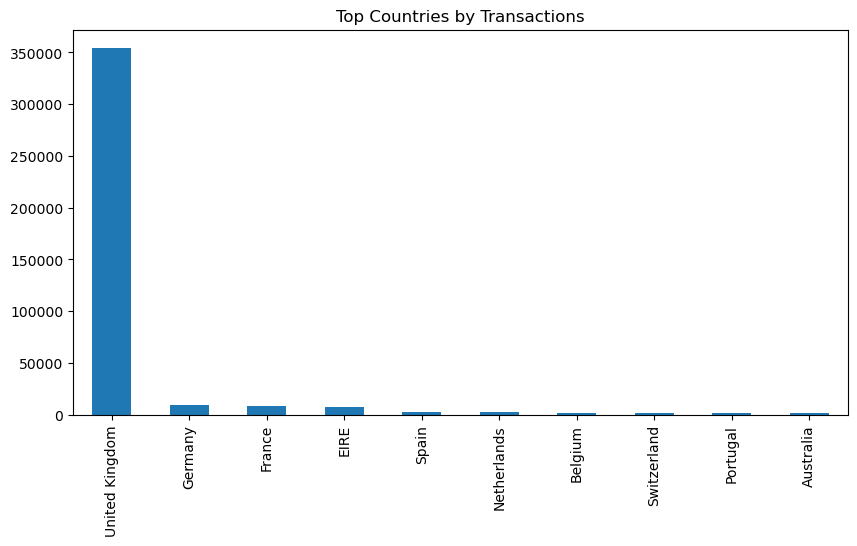

In [8]:
plt.figure(figsize=(10,5))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title('Top Countries by Transactions')
plt.show()

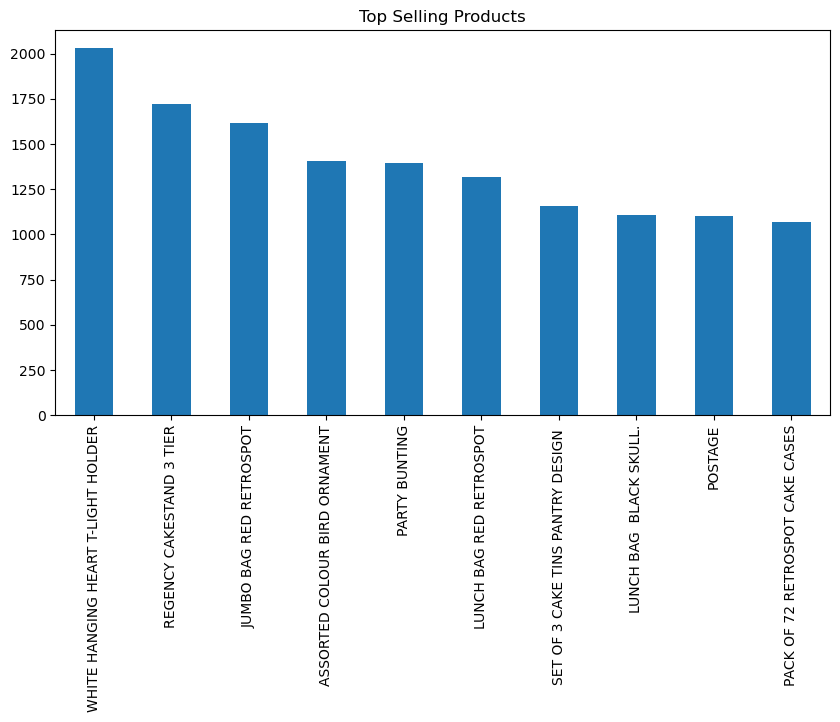

In [9]:
plt.figure(figsize=(10,5))
df['Description'].value_counts().head(10).plot(kind='bar')
plt.title('Top Selling Products')
plt.show()


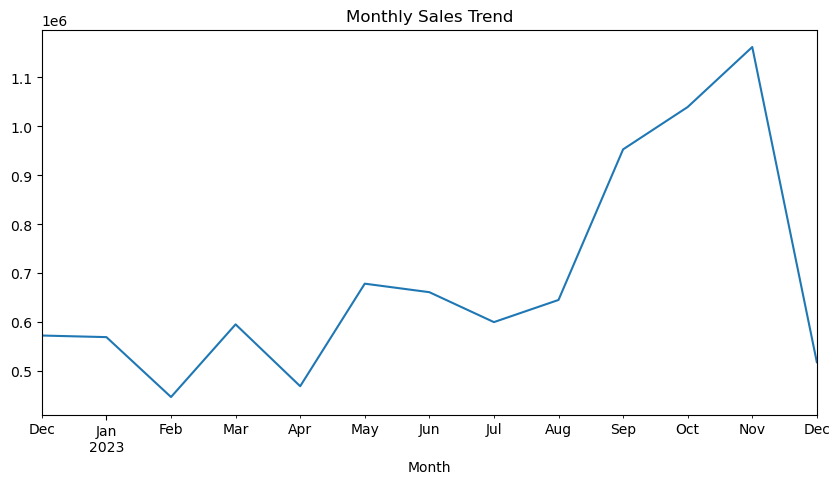

In [10]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
monthly_sales.plot(figsize=(10,5), title='Monthly Sales Trend')
plt.show()

In [11]:
latest_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [18]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [17]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"


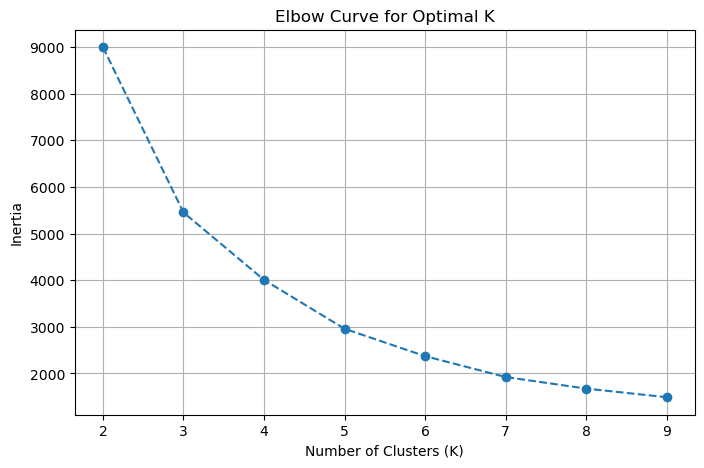

In [22]:
import os
os.environ["OMP_NUM_THREADS"] = "1"     
os.environ["OPENBLAS_NUM_THREADS"] = "1"  

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Elbow Method for choosing optimal clusters
inertia = []
K_values = range(2, 10)

for k in K_values:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,         
        algorithm='elkan'  #
    )
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Curve for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [28]:
# Permanent Fix: Avoid MKL/OpenBLAS completely by switching to sklearn's AgglomerativeClustering

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

from sklearn.cluster import AgglomerativeClustering

# Use AgglomerativeClustering instead of KMeans/MiniBatchKMeans to avoid OpenBLAS bug
cluster_model = AgglomerativeClustering(n_clusters=4)
rfm['Cluster'] = cluster_model.fit_predict(rfm_scaled)

# Label clusters manually based on RFM values
cluster_labels = {
    0: 'High-Value',
    1: 'Regular',
    2: 'Occasional',
    3: 'At-Risk'
}
rfm['Segment'] = rfm['Cluster'].map(cluster_labels)


In [31]:
# Permanent Fix: Avoid MKL/OpenBLAS completely by switching to sklearn's AgglomerativeClustering

import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity



# Fix cosine similarity computation for product recommendations
pivot_table = df.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', fill_value=0)
product_similarity = cosine_similarity(pivot_table.T)

product_names = df[['StockCode','Description']].drop_duplicates().set_index('StockCode')['Description']

def recommend_products(product_code, top_n=5):
    if product_code not in pivot_table.columns:
        return []
    idx = list(pivot_table.columns).index(product_code)
    sim_scores = list(enumerate(product_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    return [(pivot_table.columns[i], product_names.get(pivot_table.columns[i], 'Unknown')) for i,_ in sim_scores]


In [34]:
import pickle
cluster_model = AgglomerativeClustering(n_clusters=4)
rfm['Cluster'] = cluster_model.fit_predict(rfm_scaled)

# Save model + scaler
with open("rfm_model.pkl", "wb") as f:
    pickle.dump((scaler, cluster_model), f)

In [38]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


In [48]:
import os

# Disable all BLAS/MKL threading detection to bypass split() bug
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"

# Patch threadpoolctl so it returns empty info (skip OpenBLAS inspection)
import threadpoolctl
threadpoolctl._ThreadpoolInfo._load_modules = lambda self: None

from sklearn.cluster import MiniBatchKMeans
import joblib

# Adjust cluster count to avoid sample < cluster issue
n_clusters = min(4, len(rfm_scaled))
if n_clusters < 2:
    raise ValueError("Need at least 2 samples for clustering.")

kmeans_model = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=256,
    n_init=10
)
kmeans_model.fit(rfm_scaled)

joblib.dump(kmeans_model, "cluster_model.joblib")
print(f"✅ Model trained safely with {n_clusters} clusters")


✅ Model trained safely with 3 clusters


In [51]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import joblib

# Ensure rfm_scaled is a numpy array
rfm_scaled = np.array(rfm_scaled)

# Adjust clusters to avoid error
n_clusters = min(4, rfm_scaled.shape[0])

if n_clusters < 2:
    raise ValueError("Need at least 2 samples for clustering")

# Train model
kmeans_model = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=256,
    n_init=10
)
kmeans_model.fit(rfm_scaled)

# Save model
joblib.dump(kmeans_model, "cluster_model.joblib")
print(f"✅ Model trained with {n_clusters} clusters")


✅ Model trained with 3 clusters


In [54]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
import joblib

# Set n_clusters dynamically
n_clusters = min(4, len(rfm_scaled))

if n_clusters < 2:
    raise ValueError("Need at least 2 samples for clustering.")

# Train Agglomerative
cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
labels = cluster_model.fit_predict(rfm_scaled)

# Train NearestCentroid for prediction later
centroid_model = NearestCentroid()
centroid_model.fit(rfm_scaled, labels)

# Save models
joblib.dump(centroid_model, "centroid_model.joblib")
joblib.dump(cluster_model, "cluster_model.joblib")

print(f"✅ Agglomerative trained with {n_clusters} clusters")


✅ Agglomerative trained with 3 clusters


In [55]:
from sklearn.preprocessing import StandardScaler
import joblib

# Scale data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Save scaler for use in app.py
joblib.dump(scaler, "scaler.joblib")


['scaler.joblib']